In [70]:
import numpy as np
import sys
sys.path.append('../../')
import set_plot_sizes
sys.path.append('../../cosmosis_wrappers/') # change to correct path
import ABC_saved_sims_multiparam

import corner

In [2]:
modelversion = 11
fit_with_lhs = True

In [3]:
if fit_with_lhs:
    fisher = np.load(f'data/realfisher_{modelversion}_False.npy')
    summary = np.load(f'data/realsummary_{modelversion}_False.npy')
    lhd_summary = np.load(f'data/lhd_summaries_{modelversion}_False.npy')
    thetas = np.load(f'data/theta_lhd_{modelversion}_False.npy')
else:
    # Fit the ABC
    data_dir = '/data1/osinga/master_research_project/master_research_project/learning_purposes/v2_IMNN/weak_lensing_multibins/2param/sigma8/preloaded_data_sigma8/ABC_results'
    
    fisher = np.load(f'{data_dir}/abc{modelversion}fisher.npy')
    summary = np.load(f'{data_dir}/abc{modelversion}summary.npy')
    # Not actually lhd_summary, but rather ABC summaries
    lhd_summary = np.load(f'{data_dir}/abc{modelversion}summaries.npy')
    thetas = np.load(f'{data_dir}/abc{modelversion}parameters.npy')
    
    # Only use a random subset
    number_to_use = 400
    indices_to_use = np.random.choice(len(thetas),number_to_use
                                    ,replace=False)
    lhd_summary = lhd_summary[indices_to_use]
    thetas = thetas[indices_to_use]

In [4]:
print (fisher)
print ()
print (np.cov(lhd_summary,rowvar=False))

[[3955726.  1307161.2]
 [1307161.2 1727794.6]]

[[4.98620002e-03 1.81136769e-01]
 [1.81136769e-01 9.42549808e+00]]


In [5]:
w, v  = np.linalg.eig(np.cov(lhd_summary,rowvar=False))
print (w)
print (v)

[1.50460498e-03 9.42897968e+00]
[[-0.99981533 -0.01921726]
 [ 0.01921726 -0.99981533]]


In [6]:
print (np.dot(v, summary.T))
print ()
print (np.dot(v.T,np.dot(np.cov(lhd_summary,rowvar=False),v)))

[[  4.90341938]
 [154.73764385]]

[[ 1.50460498e-03 -2.77555756e-17]
 [-4.58820807e-17  9.42897968e+00]]


In [7]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


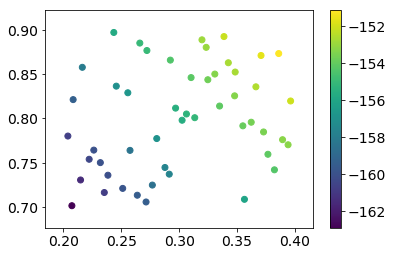

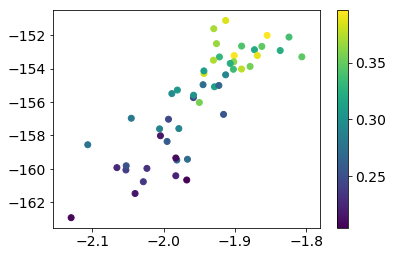

In [8]:
plt.scatter(thetas[:,0], thetas[:,1], c = lhd_summary[:,1])
plt.colorbar()
plt.show()

plt.scatter(lhd_summary[:,0], lhd_summary[:,1], c = thetas[:,0])
plt.colorbar()
plt.show()

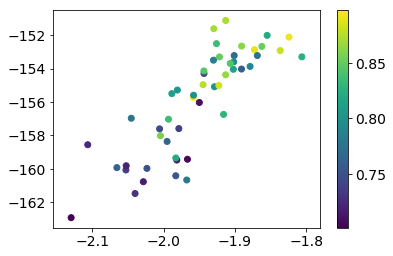

In [9]:
plt.scatter(lhd_summary[:,0], lhd_summary[:,1], c = thetas[:,1])
plt.colorbar()

In [10]:
new_lhd_summary = np.zeros_like(lhd_summary)

In [11]:
for i in range(len(lhd_summary)):
    new_lhd_summary[i,:] = np.dot(v.T, lhd_summary[i,:])

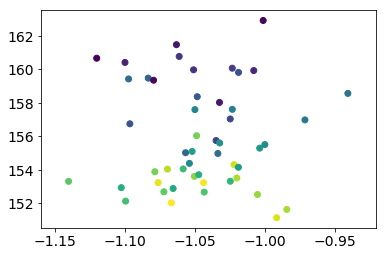

In [12]:
plt.scatter(new_lhd_summary[:,0], new_lhd_summary[:,1], c = thetas[:,0])

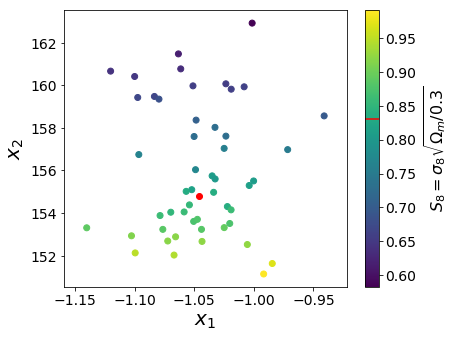

In [13]:
fig, ax = plt.subplots(figsize=([6.4, 4.8]))
plt.scatter(new_lhd_summary[:,0],new_lhd_summary[:,1]
            ,c=thetas[:,1]*np.sqrt(thetas[:,0]/0.3));
plt.xlabel("$x_1$",fontsize=20)
plt.ylabel("$x_2$",fontsize=20)
cbar = plt.colorbar()
cbar.ax.hlines(0.811*np.sqrt(0.315/0.3), *cbar.ax.get_xlim(), colors='r')
plt.scatter(*np.dot(v.T, summary[0]), c='red')
cbar.set_label('$S_8 = \sigma_8 \sqrt{\Omega_m/0.3}$');
# plt.legend(frameon=False);
plt.tight_layout()
plt.savefig(f'./x1x2scatter_{modelversion}_remapped.png')
plt.show()

In [14]:
np.cov(lhd_summary,rowvar=False)

array([[4.98620002e-03, 1.81136769e-01],
       [1.81136769e-01, 9.42549808e+00]])

In [15]:
np.dot(v.T, v)

array([[1., 0.],
       [0., 1.]])

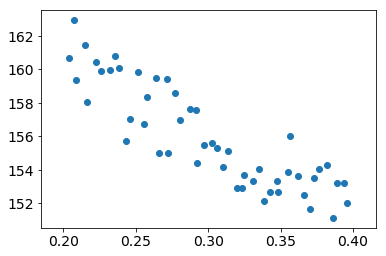

In [16]:
plt.scatter(thetas[:,0], new_lhd_summary[:,1])

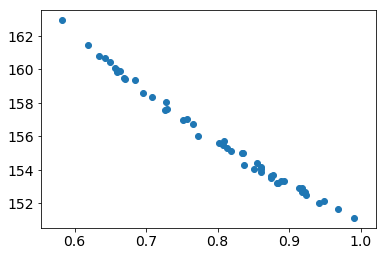

In [17]:
plt.scatter(thetas[:,1]*(thetas[:,0]/0.3)**.5, new_lhd_summary[:,1])

In [18]:
import george

In [19]:
from george import kernels

In [20]:
y = new_lhd_summary[:,1]
t = thetas.copy()
# transform s8 to sigma8
# t[:,1] = t[:,1]*(t[:,0]/0.3)**.5

In [21]:
np.var(y,ddof=0), np.var(y,ddof=1)

(9.240395, 9.428974)

In [22]:
# kernel = 100*kernels.ExpSquaredKernel(20. , ndim = 2)
if fit_with_lhs: 
    kernel = np.var(y, ddof=1)*kernels.ExpSquaredKernel(5, ndim = 2)
else:
    kernel = np.var(y, ddof=1)*kernels.ExpSquaredKernel(10, ndim = 2)

In [23]:
gp = george.GP(kernel, mean=np.mean(y), fit_mean=True)

In [24]:
gp.compute(t) # this is done below too.

In [25]:
print (gp.get_parameter_names())
print (gp.get_parameter_vector())
# mean value, np.log(100/2) and np.log(20)

# previously found best values; (for modelversion=10)
# [-180.80182103    1.31034006   -6.7679703 ]

('mean:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0')
[155.95684814   1.55064012   1.60943791]


In [26]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.set_parameter_vector(p)
    ll = gp.lnlikelihood(y, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.set_parameter_vector(p)
    return -gp.grad_lnlikelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(t)

# Print the initial ln-likelihood.
print(gp.lnlikelihood(y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
print (p0)
results = op.minimize(nll, p0, jac=grad_nll)
print (results.x)
# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.lnlikelihood(y))


-9632112615.137333
[155.95684814   1.55064012   1.60943791]
[155.95685178   1.79903221   0.63045815]
-8762418059.659454


In [43]:
print (f'sigma_f: {np.exp(results.x[1])*2}')
print (f'l      : {np.exp(results.x[2])}')

sigma_f: 12.087591061076905
l      : 1.8784710086392553


In [28]:
t0, t1 = np.linspace(0.2,0.4, 20), np.linspace(0.7,0.9, 20)
tnew = np.meshgrid(t0,t1)
# tnew is (400,2)
tnew = np.array(tnew).reshape(2,-1).T
tt0, tt1 = np.meshgrid(t0,t1)

In [29]:
mu, cov = gp.predict(y, tnew)

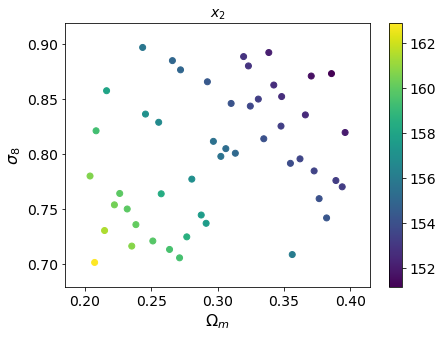

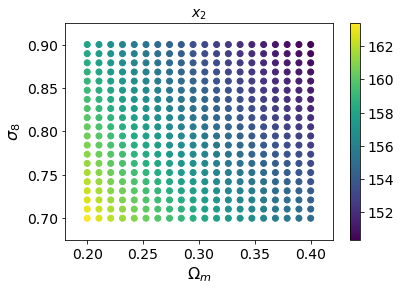

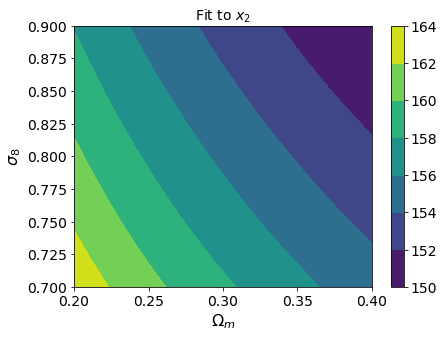

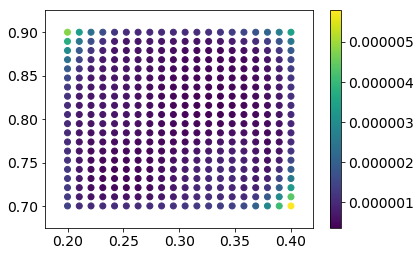

In [30]:
fig, ax = plt.subplots(figsize=([6.4, 4.8]))
plt.scatter(t[:,0], t[:,1] , c = y)
plt.xlabel('$\Omega_m$')
plt.ylabel('$\sigma_8$')
cbar = plt.colorbar()
plt.title('$x_2$')
plt.tight_layout()
plt.savefig('./x2_scatter_remapped.png',bbox_inches='tight')
plt.show()
plt.close()

plt.scatter(tt0.flatten(), tt1.flatten(), c = mu)
plt.xlabel('$\Omega_m$')
plt.ylabel('$\sigma_8$')
cbar = plt.colorbar()
plt.title('$x_2$')
# plt.savefig('./x2_fit.png')
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=([6.4, 4.8]))
pl = plt.contourf(t0,t1, mu.reshape(20,20));
plt.title(f"Fit to $x_2$")
cbar = plt.colorbar(pl)
clim = (cbar.get_clim())
# In this case we do have to rescale to plot the value 
summary_loc = (summary[0,1] - cbar.vmin) / (cbar.vmax - cbar.vmin)
cbar.ax.hlines(summary_loc, *cbar.ax.get_xlim(), colors='r')
# plt.scatter(*theta_fid, c='red')
plt.xlabel('$\Omega_m$');
plt.ylabel('$\sigma_8$')
plt.tight_layout()
plt.savefig('./x2_fit_remapped.png',bbox_inches='tight')
# plt.legend(frameon=False);
plt.show()

plt.scatter(tt0.flatten(), tt1.flatten(), c = np.diag(cov)**.5)
plt.colorbar()
plt.show()
plt.close()

In [31]:
mu_old, cov_old = gp.predict(y, t)

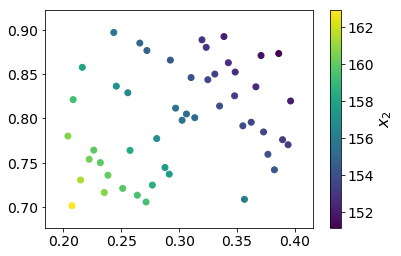

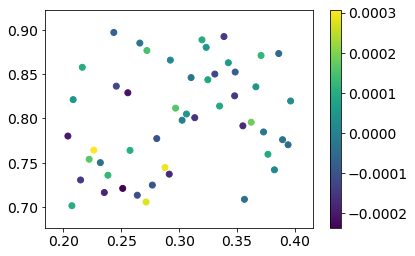

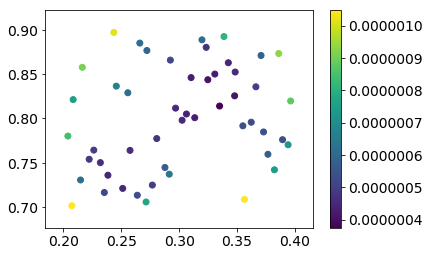

In [32]:
plt.scatter(t[:,0], t[:,1] , c = y)
cbar = plt.colorbar()
cbar.set_label('$x_2$')
plt.show()
plt.close()

plt.scatter(t[:,0], t[:,1] , c = (y-mu_old)/y)
plt.colorbar()
plt.show()
plt.close()

plt.scatter(t[:,0], t[:,1] , c = np.diag(cov_old)**.5)
plt.colorbar()
plt.show()
plt.close()

In [33]:
# tnew_pred = np.array([0.3,0.8]).reshape(1,2)
# mu_pred, cov_pred = gp.predict(y, tnew_pred)
# print (mu_pred)

### Now we perform ABC, using the Gaussian process as the network emulator. 

In [34]:
# change to the path where the IMNN git clone is located
# new version of IMNN by Tom
sys.path.insert(-1,'../../../IMNNv2/IMNN/')
import IMNN.ABC.priors as priors

In [35]:
def ABC_with_GP(draws, gp, y, real_summary, prior, fisher
                   ,uniformprior=False):
    """
    draws        -- number of draws to make
    gp           -- optimized Gaussian Process
    y            -- 50 output summary points 
    real_summary -- summary of observed data
    prior        -- specify mean lower upper etc
    fisher       -- fisher info of training data
    uniformprior -- whether to use Uniform or Gaussian prior
    
    """
    
    if uniformprior is False:
        Gaussprior = priors.TruncatedGaussian(prior["mean"],prior["variance"],prior["lower"]
                                    ,prior["upper"])
        # Draw params from Gaussian prior
        theta = Gaussprior.draw(draws)
    else:
        # Draw params from Uniform prior
        theta1 = np.random.uniform(prior['lower'][0],prior['upper'][0],draws)
        theta2 = np.random.uniform(prior['lower'][1],prior['upper'][1],draws)
        theta = np.array([theta1,theta2]).T
        
    # Calculate summaries with GP
    mu, cov = gp.predict(y, theta)
    summaries = mu.reshape(draws,1) # (draws,1)
    # Calculate distance
    differences = summaries - real_summary
    distances = np.sqrt(
        np.einsum(
            'ij,ij->i',
            differences,
            np.einsum(
                'jk,ik->ij',
                fisher,
                differences)))
    ABC_dict = dict()
    ABC_dict["summary"] = real_summary
    ABC_dict["fisher"] = fisher
    ABC_dict["parameters"] = theta
    ABC_dict["summaries"] = summaries
    ABC_dict["differences"] = differences
    ABC_dict["distances"] = distances
    
    return ABC_dict    

In [134]:
# Variables for ABC
draws = int(10000) # amount of draws

# A uniform prior
prior = { # don't want to extrapolate, so use same limits as LHS
         'lower': np.array([0.29,0.7]),
         'upper': np.array([0.33,0.9]) 
         }
# 'lower': np.array([0.29,0.7]),
#          'upper': np.array([0.33,0.9]) 

In [135]:
new_summary = np.array([np.dot(v.T, summary[0])[1]])[:,None]
print (new_summary, new_summary.shape)
abc_model = ABC_with_GP(draws, gp, y, new_summary, prior, fisher, True)

[[154.81177944]] (1, 1)


In [136]:
class holder(object):
    """Small class because plotting function requires it"""
    def __init__(self,saveversion,figuredir):
        self.modelversion = saveversion
        self.figuredir = figuredir

In [137]:
holder1 = holder(saveversion=modelversion,figuredir='./tight')
theta_fid = np.array([0.315, 0.811])
# plotting function requires this too
abc_model["MLE"] = np.nan

Epsilon is chosen to be 709.56
Number of accepted samples =  1000


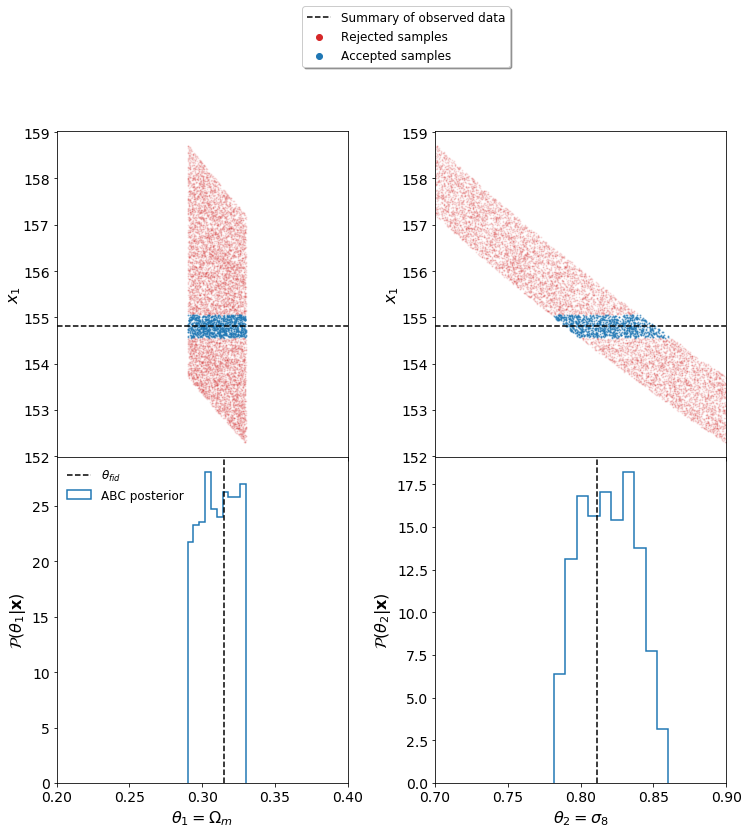

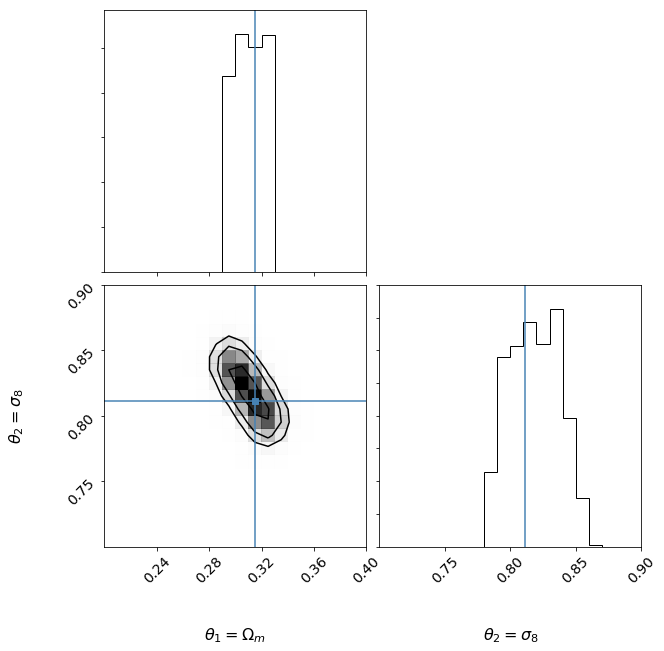

In [138]:
prior_plot =     { # simply the plot limits
         'lower': np.array([0.20,0.7]),
         'upper': np.array([0.40,0.9]) 
         }

ABC_saved_sims_multiparam.plot_ABC_2params(abc_model, holder1
    , theta_fid, prior_plot, oneD='both', hbins=10
    , epsilon=np.percentile(abc_model['distances'],10)
    ,show=True)

# Can we overplot the old posterior inferred from the actual  simulations?

In [132]:
def load_ABC_results(modelversion):
    """
    Load the results of 10,000 simulations that have been fed through a trained network 
    and compared with some fiducial simulation
    """
    data_dir = '/data1/osinga/master_research_project/master_research_project/learning_purposes/v2_IMNN/weak_lensing_multibins/2param/sigma8/preloaded_data_sigma8/ABC_results'
    abc = dict()
    for key in ['summary', 'fisher', 'parameters', 'summaries', 'differences', 'distances', 'MLE']:
        abc[key] = np.load(f'{data_dir}/abc{modelversion}{key}.npy')
    return abc

def plot_2d_posterior(abc_model, epsilon, c):
    """
    Plot both the posterior from ABC with model
    and the posterior from ABC with full forward sims
    """
    accept_indices = np.argwhere(abc_model["distances"] < epsilon)[:, 0]
    reject_indices = np.argwhere(abc_model["distances"] >= epsilon)[:, 0]

    print ('Epsilon is chosen to be %.2f'%epsilon)
    print("Number of accepted samples = ", accept_indices.shape[0])

    truths = theta_fid
    hist_kwargs = {'density':True} # add kwargs to give to matplotlib hist funct
    figc = corner.corner(abc_model["parameters"][accept_indices, :]
        , fig=fig, truths = truths
        , bins=20, hist_bin_factor=3
        , color = c, truth_color='k'
        , labels=[r'$\theta_1 = \Omega_m$ ', r'$\theta_2 = \sigma_8$']
        , plot_contours=True, smooth=True # plot smoothened posteriors
        , range=[(prior["lower"][0],prior["upper"][0])
                 , (prior["lower"][1],prior["upper"][1])]
        , hist_kwargs=hist_kwargs)


Epsilon is chosen to be 1078.62
Number of accepted samples =  4192
Epsilon is chosen to be 1078.62
Number of accepted samples =  1000


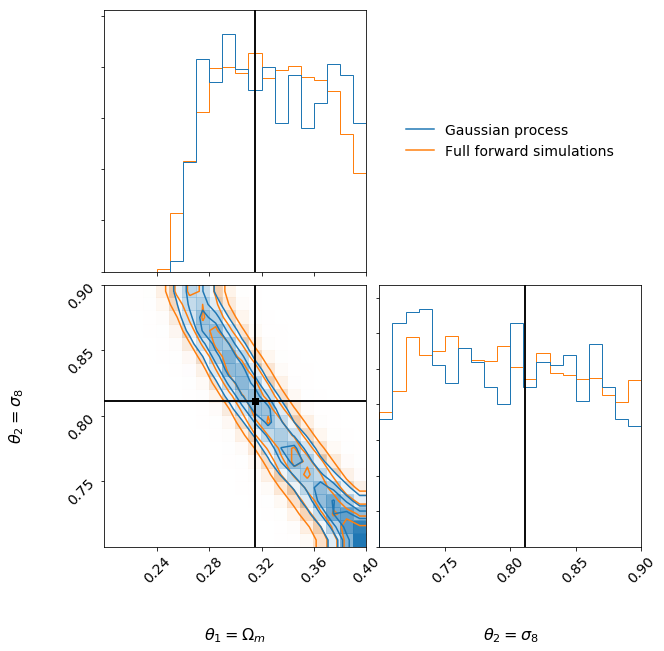

In [133]:
abc_full = load_ABC_results(modelversion=11)

epsilon=np.percentile(abc_model['distances'],10)

fig, ax = plt.subplots(2, 2, figsize = (10, 10))
plot_2d_posterior(abc_full,epsilon, c='C1')
plot_2d_posterior(abc_model,epsilon, c='C0')
ax[0,1].plot(0,0,label='Gaussian process')
ax[0,1].plot(0,0,label='Full forward simulations')
ax[0,1].legend(frameon=False,loc='center')
plt.savefig('ABC_comparison.png')
plt.show()

# plt.show()

# The LHS summaries only, just as a comparison

In [107]:
holder2 = holder(saveversion=modelversion,figuredir='./lhs_')

# Using the LHS summaries only for abc:
abc_LHS = dict()
abc_LHS["summary"] = new_summary
abc_LHS["fisher"] = fisher
abc_LHS["parameters"] = thetas
abc_LHS["summaries"] = new_lhd_summary[:,1].reshape(50,1)
differences = abc_LHS['summaries'] - abc_LHS['summary']
distances = np.sqrt(
    np.einsum(
        'ij,ij->i',
        differences,
        np.einsum(
            'jk,ik->ij',
            fisher,
            differences)))
abc_LHS["differences"] = differences
abc_LHS["distances"] = distances
np.max(distances)

23363.19730616434

Epsilon is chosen to be 2818.37
Number of accepted samples =  13


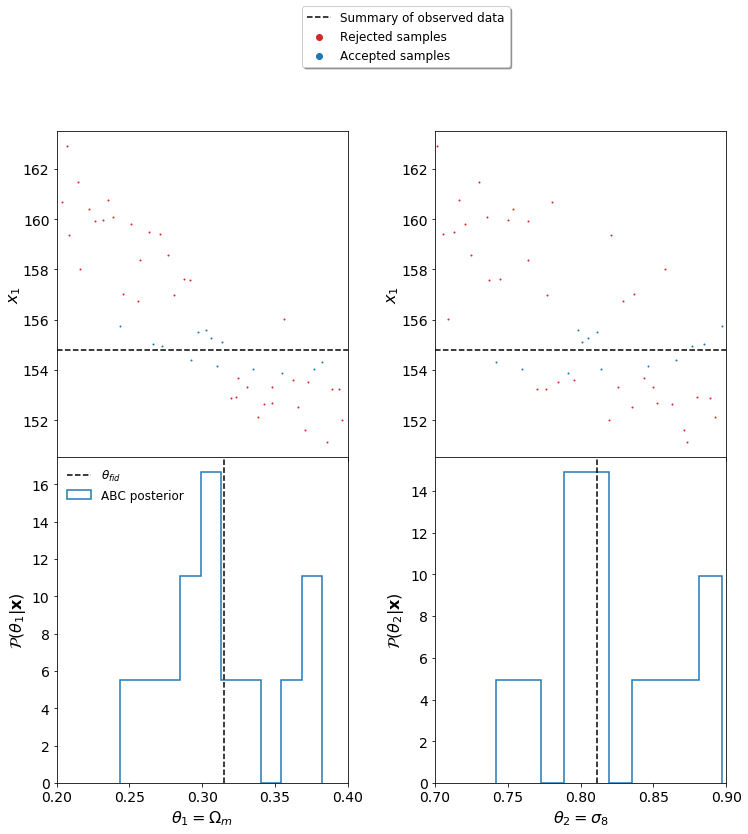

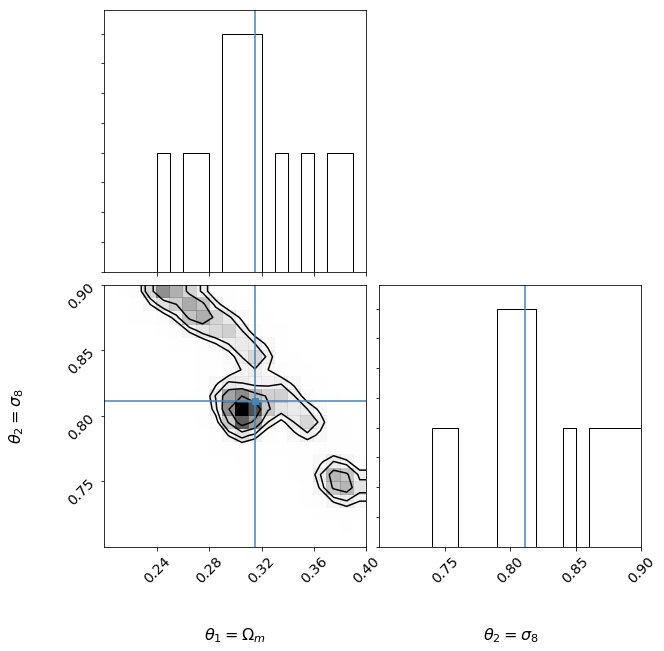

In [108]:
ABC_saved_sims_multiparam.plot_ABC_2params(abc_LHS, holder2
    , theta_fid, prior, oneD='both', hbins=10
    , epsilon=np.percentile(abc_LHS['distances'],25)
    ,show=True, alpha_reject=1, alpha_accept=1)